In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
from plaid.datasets import CATHShardedDataModule

dm = CATHShardedDataModule()
dm.setup("fit")
dl = dm.train_dataloader()
batch = next(iter(dl))

seq_to_header = {v: k for k, v in dm.train_dataset.header_to_seq.items()}

In [28]:
from plaid.utils import LatentToSequence, LatentToStructure
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
l2seq = LatentToSequence(device)
l2struct = LatentToStructure(device)
l2struct.esmfold = l2struct.esmfold.to(dtype=torch.float32)

In [29]:
x, mask, sequences = batch
headers = [seq_to_header[s] for s in sequences]
seqs = [s[:64] for s in sequences]

In [32]:
cath_ids = [h.split("|")[2].split("/")[0] for h in headers]
cath_ids[:10]

['2hfqA00',
 '3dh3B01',
 '2x6qA02',
 '2l6oA01',
 '2keoA00',
 '3k5rA02',
 '2rilA00',
 '1xovA02',
 '2losA00',
 '3fvcA03']

In [59]:
pdbstrs, metrics = l2struct.to_structure(x.to(torch.float32), seqs, num_recycles=4)

(Generating structure from latents..): 100%|██████████| 1/1 [00:21<00:00, 21.11s/it]


In [60]:
metrics

,plddt,ptm,aligned_confidence_probs,predicted_aligned_error
0,75.141884,0.753416,0.015625,3.425763
1,73.879166,0.811329,0.015625,3.084032
2,73.764053,0.758903,0.015625,3.114461
3,39.365517,0.237710,0.015625,16.648401
4,56.578186,0.356202,0.015625,10.982853
5,71.444534,0.593939,0.015625,5.531458
6,71.225548,0.610685,0.015625,4.504477
7,44.893436,0.290677,0.015625,14.074552
8,63.816181,0.574627,0.015625,8.036273
9,50.504631,0.255107,0.015625,18.744228


In [61]:
for i in range(10):
    with open("pred_from_latent_{}.pdb".format(i), "w") as f:
        f.write(pdbstrs[i])

In [62]:
pdbstr_infered = l2struct.esmfold.infer_pdbs(seqs)

In [63]:
for i in range(10):
    with open("pred_from_seq_{}.pdb".format(i), "w") as f:
        f.write(pdbstr_infered[i])

In [43]:
import os
import shutil
for i, name in enumerate(cath_ids[:10]):
    original = "/shared/amyxlu/data/cath/full/dompdb/" + name
    shutil.copy(original, f"{i}_name.pdb")
    

In [42]:
cath_ids[:10]

['2hfqA00',
 '3dh3B01',
 '2x6qA02',
 '2l6oA01',
 '2keoA00',
 '3k5rA02',
 '2rilA00',
 '1xovA02',
 '2losA00',
 '3fvcA03']

In [64]:
from plaid.utils import run_tmalign
scores = []
for i in range(10):
    tmscore = run_tmalign(f"pred_from_latent_{i}.pdb", f"pred_from_seq_{i}.pdb")
    scores.append(tmscore)

In [65]:
scores

[0.96202,
 0.99892,
 0.28071,
 0.66822,
 0.30025,
 0.98031,
 0.75533,
 0.87183,
 0.51331,
 0.38478]

(array([2., 1., 0., 1., 0., 1., 1., 0., 1., 3.]),
 array([0.28071 , 0.352531, 0.424352, 0.496173, 0.567994, 0.639815,
        0.711636, 0.783457, 0.855278, 0.927099, 0.99892 ]),
 <BarContainer object of 10 artists>)

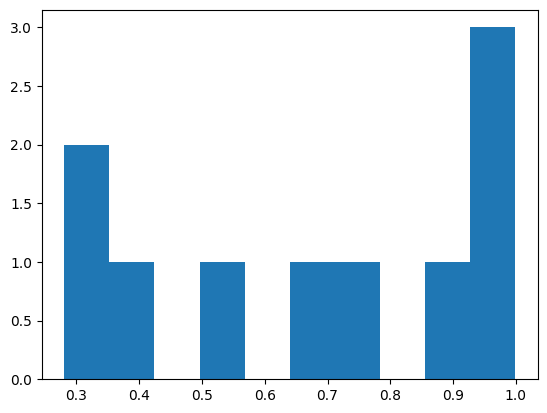

In [69]:
plt.hist(scores)

In [66]:
from plaid.utils import run_tmalign
scores2 = []
for i in range(10):
    tmscore = run_tmalign(f"pred_from_latent_{i}.pdb", f"{i}_name.pdb")
    scores2.append(tmscore)
print(scores2)

[0.64679, 0.9415, 0.32059, 0.33272, 0.44037, 0.45129, 0.60652, 0.64804, 0.28663, 0.31174]


In [67]:
from plaid.utils import run_tmalign
scores3 = []
for i in range(10):
    tmscore = run_tmalign(f"pred_from_seq_{i}.pdb", f"{i}_name.pdb")
    scores3.append(tmscore)
print(scores3)

[0.65961, 0.94377, 0.29444, 0.32714, 0.39404, 0.45055, 0.60519, 0.65165, 0.25412, 0.22379]
